In [6]:
import optuna
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score as AMI
from rock import ROCK

from util import dbscan_init

import logging
import sys

In [7]:
seed = 0
n_samples = 800
n_features = 3
n_centers = 2
jitter = 3 * 0.01
datasets = []

feature_grid = [2, 5, 10, 15, 20]

In [8]:
experiment = []
rock_results = []
other_results = []

In [9]:
def getBlobDensities(n_centers):
  return np.round([3/n_centers * x for x in range(1, n_centers + 1)], decimals=2)

In [11]:
for f in feature_grid:
    step = 0
    for s in range(seed, seed+10):
        #print(f'jitter: {j}, seed: {s}')
        dataset = make_blobs(n_samples=n_samples, centers=n_centers, n_features=f, 
                             cluster_std=getBlobDensities(n_centers), random_state=s)
        run = {}
        run['step'] = step
        run['n_samples'] = n_samples
        run['n_centers'] = n_centers
        run['jitter'] = jitter
        run['features'] = f
        scaler = StandardScaler()
        data = scaler.fit_transform(dataset[0])
        kmeans = KMeans(n_clusters=n_centers, random_state=seed).fit(data).labels_
        eps, min_pts = dbscan_init(data)
        eps, min_pts = (0.2, 4)
        dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(data).labels_
        run['eps'] = eps
        run['min_pts'] = min_pts
        spectral = SpectralClustering(n_clusters=2).fit(data).labels_
        bandwidth = estimate_bandwidth(data)

        run['bandwidth'] = bandwidth
        mean_shift = MeanShift(bandwidth=bandwidth).fit(data).labels_

        rock = ROCK(tmax=15).fit(data).labels_

        gt = dataset[1]
        rock_results.append(AMI(rock, gt))
        other_results.append(np.max([AMI(kmeans, gt), AMI(dbscan, gt), AMI(spectral, gt), AMI(mean_shift, gt)]))

        run['ROCK'] = AMI(rock, gt)
        run['K_MEANS'] = AMI(kmeans, gt)
        run['DBSCAN'] = AMI(dbscan, gt)
        run['SPECTRAL'] = AMI(spectral, gt)
        run['MEAN_SHIFT'] = AMI(mean_shift, gt)

        step += 1

        experiment.append(run)

In [12]:
pd.DataFrame(experiment).to_csv('den_blobs_analysis_dim.csv')

In [13]:
mean_std = pd.DataFrame(experiment).groupby('features')[['ROCK', 'DBSCAN', 'K_MEANS', 'SPECTRAL', 'MEAN_SHIFT']].agg([np.mean, np.std])

In [16]:
mean_std

ROCK              DBSCAN             K_MEANS            \
              mean       std      mean       std      mean       std   
features                                                               
2         0.587182  0.353728  0.255543  0.278681  0.559830  0.282216   
5         0.914408  0.164608  0.027087  0.046485  0.899446  0.159061   
10        0.997476  0.005321  0.000000  0.000000  0.994191  0.009751   
15        0.998738  0.003991  0.000000  0.000000  0.998738  0.003991   
20        1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   

          SPECTRAL           MEAN_SHIFT            
              mean       std       mean       std  
features                                           
2         0.512976  0.305497   0.359480  0.417009  
5         0.894939  0.182014   0.768101  0.393587  
10        0.997476  0.005321   0.975207  0.021308  
15        0.998738  0.003991   0.967324  0.019432  
20        1.000000  0.000000   0.953461  0.018854

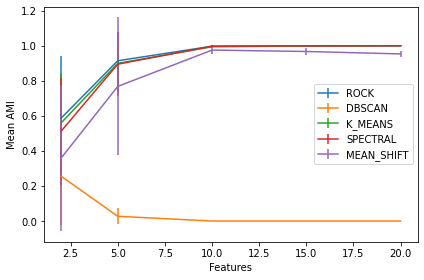

In [15]:
import matplotlib.pyplot as plt

plt.errorbar(mean_std.index, mean_std['ROCK']['mean'], yerr=mean_std['ROCK']['std'])
plt.errorbar(mean_std.index, mean_std['DBSCAN']['mean'], yerr=mean_std['DBSCAN']['std'])
plt.errorbar(mean_std.index, mean_std['K_MEANS']['mean'], yerr=mean_std['K_MEANS']['std'])
plt.errorbar(mean_std.index, mean_std['SPECTRAL']['mean'], yerr=mean_std['SPECTRAL']['std'])
plt.errorbar(mean_std.index, mean_std['MEAN_SHIFT']['mean'], yerr=mean_std['MEAN_SHIFT']['std'])

plt.legend(['ROCK', 'DBSCAN', 'K_MEANS', 'SPECTRAL', 'MEAN_SHIFT'])
plt.xlabel('Features')
plt.ylabel('Mean AMI')
plt.tight_layout()
plt.savefig('two_moons_num_jitter.png')

In [10]:
from matplotlib import pyplot as plt

In [11]:
colors = ['red', 'green']

In [12]:
dataset = make_blobs(n_samples=800, centers=2, n_features=20, 
                             cluster_std=getBlobDensities(2), random_state=s)

NameError: name 'getBlobDensities' is not defined

In [8]:
pyplot.scatter(x=dataset[0][:, 0], y=dataset[:, 1], marker='.', c=datasets[3][1])

NameError: name 'pyplot' is not defined

In [ ]:
np.mean(np.array(rock_results) - np.array(other_results))

In [ ]:
np.mean(rock_results) - np.mean(other_results)